<a href="https://colab.research.google.com/github/RayGone/SentimentAnalysis/blob/phase2/Experiments/SVM/GPT2SVM_4SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers tokenizers datasets huggingface_hub --quiet

import numpy as np
import random
import os
import tensorflow as tf
from transformers import set_seed

rand_seed = 9

def seed_everything(seed=0):
    random.seed(seed) # random
    os.environ['PYTHONHASHSEED'] = str(seed) # python enviroment
    np.random.seed(seed) # numpy
    tf.keras.utils.set_random_seed(seed) # tensorflow
    tf.random.set_seed(seed) # tensorflow
    set_seed(seed) # hugging_face transformer

seed_everything(rand_seed)

In [ ]:
from transformers import PreTrainedTokenizerFast, BertTokenizerFast, TFAutoModel
import datasets

gptModel ='raygx/GNePT-NepSA'  ## 'raygx/GPT-NepSA-T2' ## Fine-tuned Model ## 'raygx/Nepali-GPT2-CausalLM' ## Pre-Trained LM ##
gptTokenizer = PreTrainedTokenizerFast.from_pretrained(gptModel,padding_side='left')
gptModel = TFAutoModel.from_pretrained(gptModel)

gptModel.config

Some layers from the model checkpoint at raygx/GNePT-NepSA were not used when initializing TFGPT2Model: ['score']
- This IS expected if you are initializing TFGPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFGPT2Model were initialized from the model checkpoint at raygx/GNePT-NepSA.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


GPT2Config {
  "_name_or_path": "raygx/GNePT-NepSA",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2ForSequenceClassification"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": null,
  "embd_pdrop": 0.1,
  "eos_token_id": null,
  "id2label": {
    "0": "NEUTRAL",
    "1": "POSITIVE",
    "2": "NEGATIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 2,
    "NEUTRAL": 0,
    "POSITIVE": 1
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "pad_token_id": 3,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 5

In [ ]:
print("#######################Using NepCov19Tweets#########################")
data = datasets.load_dataset("raygx/NepCov19TweetsPlus")

data = data.rename_columns({"Sentiment":"label","Sentences":"text"})
data

#######################Using NepCov19Tweets#########################


DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 41541
    })
})

In [ ]:
data = data.shuffle(rand_seed)
data = data['train'].train_test_split(test_size=0.2)
data

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 33232
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8309
    })
})

In [ ]:
def prepareLabels(row):
    if row['label'] == -1:
        row['label'] = 2

    return row

data = data.map(
        prepareLabels,
        num_proc=4)

data

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 33232
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8309
    })
})

In [ ]:
import tensorflow as tf

class GPTEmbedding(tf.keras.layers.Layer):
  def __init__(self, model,tokenizer, max_token_len=128,padding='max_length', trailing_context=4,truncation=True):
    super().__init__()
    self.embedding = model
    self.tokenizer = tokenizer
    self.tokenizer.padding_side = 'left'
    self.max_token = max_token_len
    self.padding = padding
    self.truncation = truncation
    self.trailing_context = trailing_context
    self.trainable=False

  def call(self, x):
    embeddings = self.embedding(
                  self.tokenizer(x,padding=self.padding,truncation=self.truncation,max_length=self.max_token,return_tensors='tf')
                )[0][:,-self.trailing_context:,:]

    return tf.reduce_logsumexp(embeddings,axis=1)


### Preparing Training Data

In [ ]:
from tqdm.auto import tqdm

gptEmbd = GPTEmbedding(model=gptModel,tokenizer=gptTokenizer,trailing_context=2,max_token_len=100)

X = None
batch = 32
for i in tqdm(range(0,data['train'].num_rows,batch)):
    feat = gptEmbd(data['train'][i:i+batch]['text'])

    if i==0:
        X = feat
    else:
        X = np.concatenate([X,feat],axis=0)

X.shape

  0%|          | 0/1039 [00:00<?, ?it/s]

(33232, 768)

## Training

In [ ]:
%%time
from sklearn import svm

y = data['train']['label']
clf = svm.SVC()  ## default 'rbf'
clf.fit(X, y)
clf.classes_

CPU times: user 5min 14s, sys: 506 ms, total: 5min 15s
Wall time: 5min 15s


array([0, 1, 2])

### Preparing Test Data

In [ ]:
testX = None
for i in tqdm(range(0,data['test'].num_rows,batch)):
    feat = gptEmbd(data['test'][i:i+batch]['text'])

    if i==0:
        testX = feat
    else:
        testX = np.concatenate([testX,feat],axis=0)

  0%|          | 0/260 [00:00<?, ?it/s]

## Evaluation

In [ ]:
%%time
predictions = clf.predict(testX)

CPU times: user 1min 22s, sys: 216 ms, total: 1min 22s
Wall time: 1min 22s


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y = data['test']['label']
print("F1-Score",f1_score(np.array(y),predictions,average='weighted'))
print("Precision-Score",precision_score(np.array(y),predictions,average='weighted'))
print("Recall-Score",recall_score(np.array(y),predictions,average='weighted'))
print("accuracy_Score",accuracy_score(np.array(y),predictions))

F1-Score 0.8232616283786472
Precision-Score 0.8281299992261018
Recall-Score 0.823083403538332
accuracy_Score 0.823083403538332


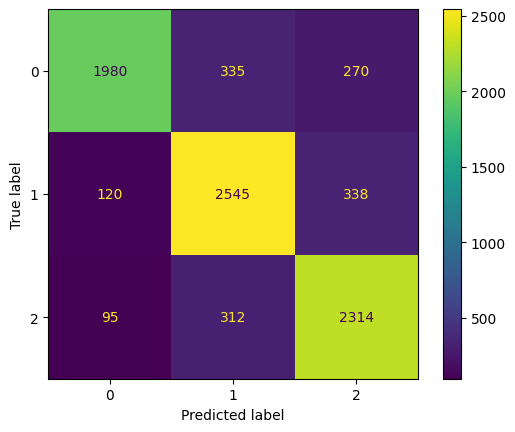

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(np.array(y),predictions,num_classes=3).numpy())
cmd.plot()